# Lab 3

Saransh Kacharia
<br>
October 25th 2020

## Problem 1

In our first example we are looking at the temperature reading (meta-data) associated with an experiment. For the experiment to work reliably, the temperature should be at around 12 Kelvin, and if we look at the data it is mostly consistent with 12 Kelvin to within the 0.4 degree precision of the thermometry and the thermal control system (standard deviation).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
import pandas as pd
from scipy import stats

In [2]:
#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

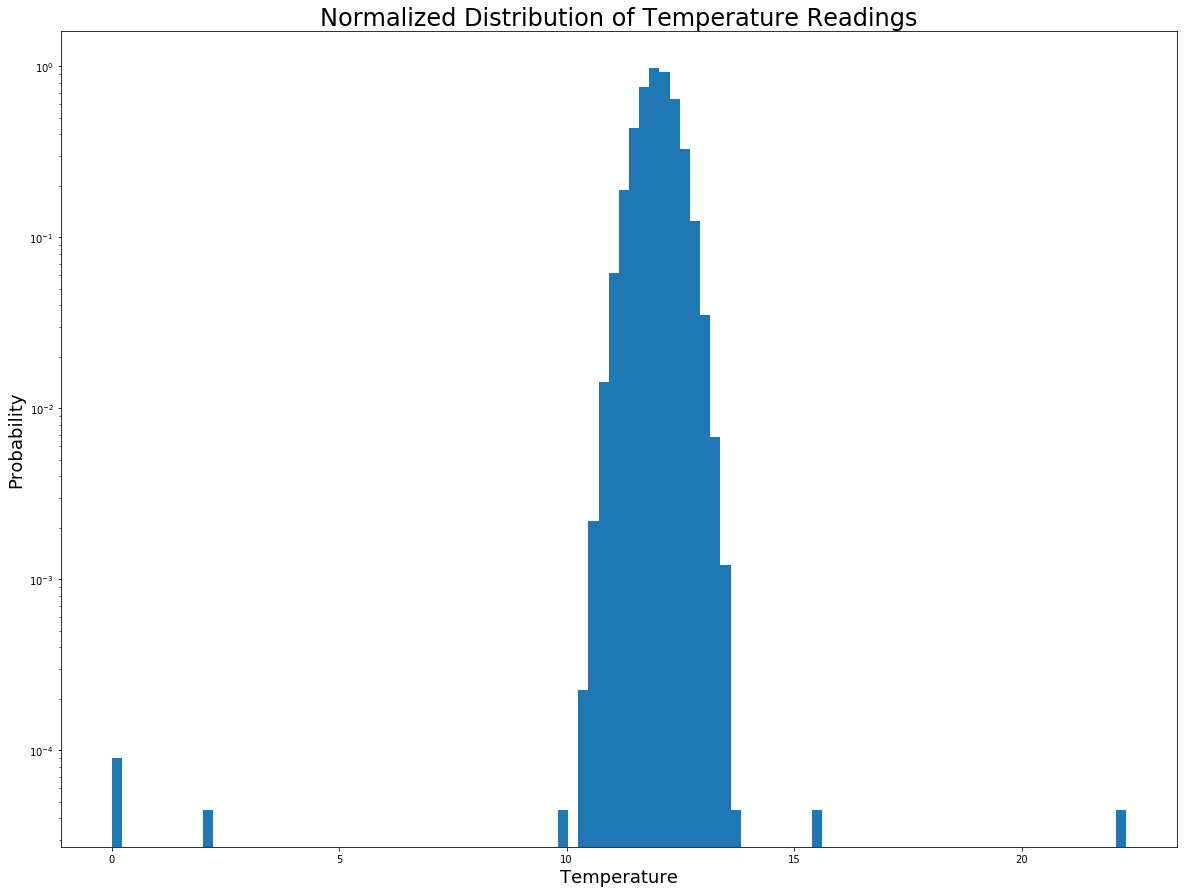

In [3]:
badData = np.array([10., 10.3, 2.1, 0., 0., 15.6, 22.3, 12.7])
goodData = stats.norm.rvs(loc = 12., scale = 0.4, size = 100000)
data = np.append(goodData, badData)
fig, ax = plt.subplots(1, 1)
ax.hist(data, 100, density=True)
plt.yscale('log')
plt.title('Normalized Distribution of Temperature Readings', fontsize = 24)
plt.ylabel('Probability', fontsize = 18)
plt.xlabel('Temperature', fontsize = 18)
#x = np.linspace(4.95,5.05,1000)
#ax.plot(x,stats.norm.pdf(x,loc = 5., scale = 0.01),linewidth = 8,alpha = 0.7)
plt.show()

We want to remove the 'bad' data points, to do this we have to find them. A statistical question we can ask is "What is the probability of this point to exist in this distribution?". After we ask this question for each point, we can get rid of points with too low of a probability to exist so we conclude that those points were errors. Another equivalent way to look at this is to exclude data points that exceed some defined sigma value.

Let's decide that any data points that have a sigma value of over $x$ sigma, we exclude it. We will test sigma values of $x = 5$, $x = 3$, $x = 2$

In [4]:
mu = np.mean(data)
std = np.std(data)

def truthTable(sigmaval):
    
    min = mu - sigmaval*std
    max = mu + sigmaval*std

    goodDataSlim = goodData[np.logical_and(goodData>min, goodData<max)]
    badDataSlim = badData[np.logical_and(badData>min, badData<max)]

    truepos = goodDataSlim.size
    trueneg = goodData.size - goodDataSlim.size
    falsepos = badDataSlim.size
    falseneg = badData.size - badDataSlim.size

    table = pd.DataFrame(data=[[truepos,falsepos],[trueneg,falseneg]],
                     index=["Positive", "Negative"],
                     columns=["True", "False"])
    print(f'Truth table for {sigmaval:.2f} sigma:')
    return table

In [5]:
truthTable(5)

Truth table for 5.00 sigma:


,True,False
Positive,100000,3
Negative,0,5


In [6]:
truthTable(5)

Truth table for 5.00 sigma:


,True,False
Positive,100000,3
Negative,0,5


In [7]:
truthTable(4.5)

Truth table for 4.50 sigma:


,True,False
Positive,100000,2
Negative,0,6


In [8]:
truthTable(2)

Truth table for 2.00 sigma:


,True,False
Positive,95723,1
Negative,4277,7


In [9]:
requiredSigma = np.min(np.abs(badData-mu)/std)
print(f'Required Sigma to remove all bad data: {requiredSigma:.2f}\n')
truthTable(requiredSigma)

Required Sigma to remove all bad data: 1.72

Truth table for 1.72 sigma:


,True,False
Positive,91938,0
Negative,8062,8


Descreasing the sigma threshold allows for more bad data to be thrown out but it comes with the consequence of throwing good data out as well. If we select a sigma of 1.72 we throw out all bad data (false positives) but we also throw out 7.9K good data points. Which is almost 8% of the good data points. 

If we dont wan't to throw out any good data, and we are okay with having some bad data. We can chose a sigma of 4.5 because that sigma value ensures we get all the good data points, while exluding the most amout of bad data points, we remain with 2 bad data points.

So the question now becomes, what is more important? Do we want no false positives, no true negatives, something in between? The answer to these questions are essential to find a threshold sigma value.

## Problem 2

In this example we will be looking for asteroids. If we look at the alignment of stars on subsequent images, they don't perfectly align due to atmospheric and instrumental effects (even ignoring proper motion). The resulting distribution is two dimensional, and for this lab let's assume it is a 2D Gaussian with 1 arcsecond RMS.

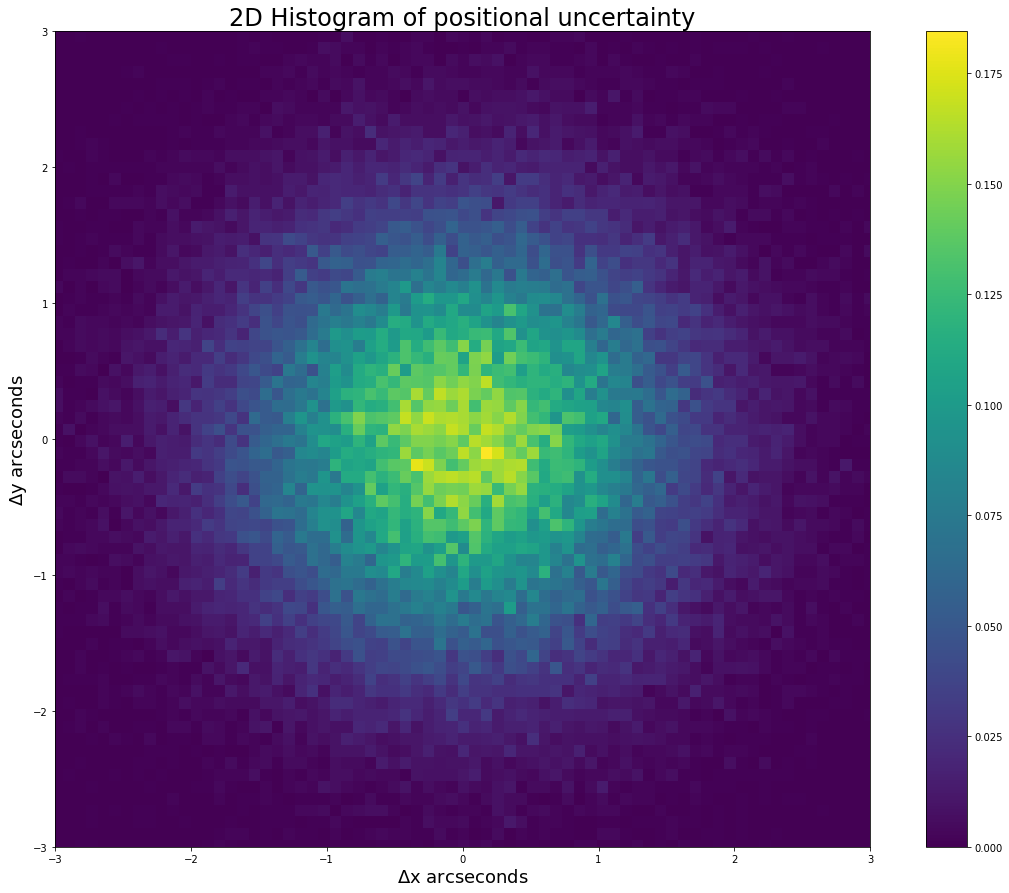

In [10]:
a = np.vstack((stats.norm.rvs( scale = 1, size = 100000), stats.norm.rvs( scale = 1, size = 100000)))
a.shape
fig, ax = plt.subplots(1, 1)
h = ax.hist2d(a[0,:],a[1,:],bins=100, density=True);
ax.set_aspect('equal', 'box')
plt.xlim([-3 , 3])
plt.ylim([-3 , 3])
plt.title("2D Histogram of positional uncertainty", fontsize = 24)
plt.ylabel("$\Delta$y arcseconds", fontsize = 18)
plt.xlabel("$\Delta$x arcseconds", fontsize = 18)
plt.colorbar(h[3], ax=ax)
plt.show()

If we have a potential asteroid we want to see significant movement between the images, the movement is displacement in each axis $\Delta x$ arcseconds and $\Delta y$ arcseconds the total distance is $D = \sqrt{(\Delta x)^2+(\Delta y)^2}$ arcseconds.

If we want '5 sigma' detection of movement, the statistical question we are asking is "What distance would an asteroid have to travel to have a 5 sigma certainty that it isn't background noise". In math this question looks like.

Mathematically, the square root of the sum of the squares of two normal distributions is a Rayleigh distribution.

$1 - \frac{1}{\sqrt{2 \pi}} \int_{-\infty}^5 e^{\frac{-x^2}{2}}\, dx = 1 - \int_0^d xe^{\frac{-x^2}{2}}\, dx$

If we solve the above equation for $d$, we get the distance required for 5 sigma

In [11]:
sigma = 1 - stats.norm.cdf(5)
distance = stats.rayleigh.ppf(1 - sigma)
print(f'Distance for 5 sigma confidence: {distance:.2f} arcseconds')

Distance for 5 sigma confidence: 5.49 arcseconds


## Problem 3

Cosmic rays are charged particles—usually protons or electrons but can include atomic nuclei such a alpha particles (helium) or iron. Because of their charge cosmic rays spiral in the magnetic field of the galaxy. From the perspective of the Earth they appear to be coming uniformly from all directions like a high energy gas, and the direction the cosmic ray is travelling when it reaches the Earth tells us nothing about where it came from because we don't know what tortured path it has taken through the galaxy to reach us. However, at trillion electron volt energies and above, the spiral loops are fairly big and the sun and the moon will block cosmic rays. This means the sun and the moon appear as holes in the cosmic ray sky (cosmic rays from that direction are absorbed).

Assume a moon sized patch on the sky we normally have a cosmic ray rate of 1 cosmic ray per minute (arrivals are random in time). If we can observe where the moon is for 8 hours per night (not too close to the horizon) and we observe for 15 days and see 6800 cosmic rays, what is the signficance of our moon shadow detection?

The question we are trying to answer is "What is the signficance of seeing 6800 cosmic rays over 15 days, coming from a background which produces 1 cosmic ray per minute?"

First, we can start with a Poisson distribution for 1 minute.

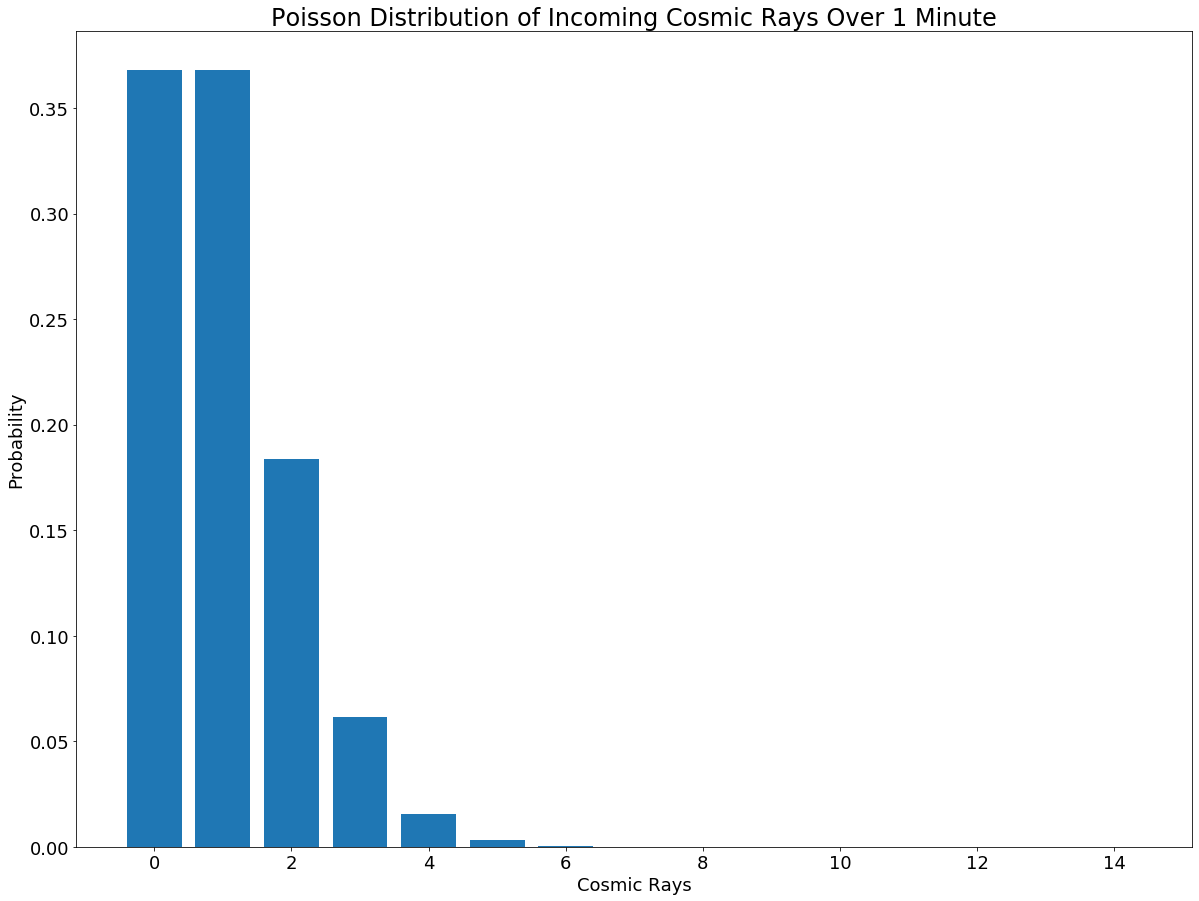

In [19]:
plt.tick_params(labelsize = 18)
mu = 1
x = np.arange(stats.poisson.ppf(0.0000000000001, mu), 
              stats.poisson.ppf(0.9999999999999, mu))
p = stats.poisson.pmf(x, mu)
plt.title('Poisson Distribution of Incoming Cosmic Rays Over 1 Minute', fontsize = 24)
plt.xlabel('Cosmic Rays', fontsize = 18)
plt.ylabel('Probability', fontsize = 18)
plt.bar(x, p)
plt.show()

In [20]:
n = 60*8*15
sump = p
for i in range(n-1):
    sump = np.convolve(sump, p)
    
x = np.arange(x[0]*n, x[-1]*n+1)

We convolve the poisson distribution for the entirety of the time scale and we get a poisson distribution of cosmic rays over the course of 15 days.

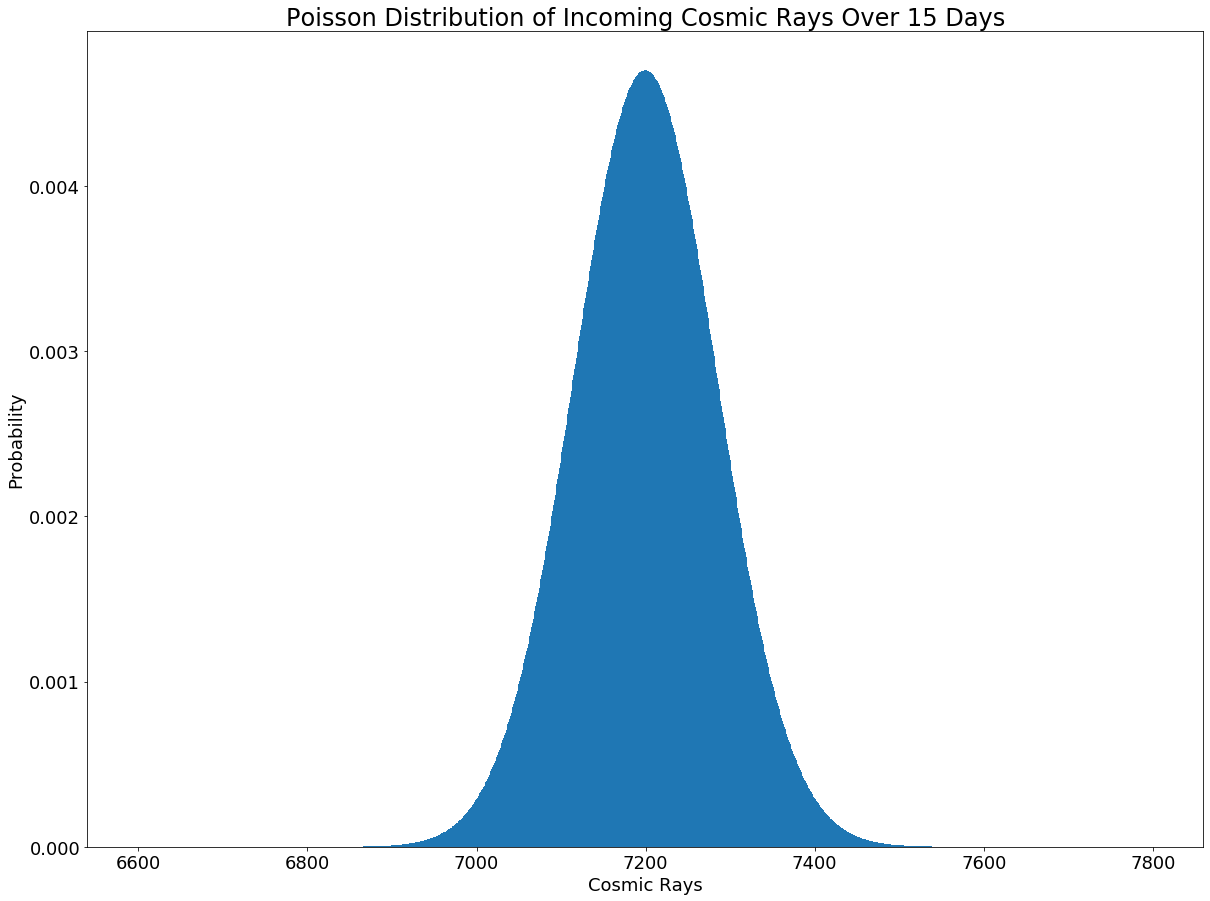

In [23]:
xcut = x[6600:7800]
sumpcut = sump[6600:7800]
plt.tick_params(labelsize = 18)
plt.title('Poisson Distribution of Incoming Cosmic Rays Over 15 Days', fontsize = 24)
plt.xlabel('Cosmic Rays', fontsize = 18)
plt.ylabel('Probability', fontsize = 18)
plt.bar(xcut, sumpcut, width=1)
plt.show()

Now, to find the significance of a measurement of 6800 Cosmic Rays we will sum the probability distribution from 0 to 6800. $\sum_{x = 0}^{6800} PDF(x) = CDF(6800)$

And then we can find the inverse of the CDF on a normal distribution to find Sigma

In [29]:
prob = sum(sump[:6800])
sig = stats.norm.ppf(1-prob)
print(f'Probability of measuring 6800 rays over 15 days: {prob:.8f}')
print(f'Sigma significance of this measurement: {sig:.2f}')

Probability of measuring 6800 rays over 15 days: 0.00000095
Sigma significance of this measurement: 4.76


We get a sigma significance of 4.76, which is almost enough significance to claim a discovery that the moon inhibits cosmic rays from being observed.